

> Tambahkan blockquote



In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Membuat model untuk sistem rekomendasi


# **Membuat desain model CNN untuk klasifikasi jenis - jenis tanah**

 kami mengambil dataset tanah dari [kagle](https://www.kaggle.com/datasets/fuadkahfi/dataset-tanah), kita mendapat 8 sampel jenis tanah dan total 880 datasets
 dengan ini kami dapat mendapatkan accuracy: 0.9601 - loss: 0.1109 - val_accuracy: 0.8909 - val_loss: 0.4921 🔥

untuk model arsitektur, kami meniru style [VGGNet CNN architecture](https://en.wikipedia.org/wiki/VGGNet). berikut model arsitektur yang kami buat:
> 320x320x3 --> 320x320x32 Conv1+ReLU --> max pooling --> 160x160x64 Conv2+ReLU --> max pooling --> 80x80x128 Conv3+ReLU --> max pooling --> Dropout(0.4) -> Flatten --> 1x1x128 fullyconnected1+ReLU --> Dropout(0.4) --> 1x1x8 fullyconnected2+softmax


---


berikut model yang kami buat :

In [2]:
#@title Install required libraries

!pip install keras~=3.8.0 \
  matplotlib~=3.10.0 \
  numpy~=2.0.0 \
  pandas~=2.2.0 \
  tensorflow~=2.18.0

print('\n\nAll requirements successfully installed.')



All requirements successfully installed.


In [3]:
#@title Load dependencies

import io

# data
import numpy as numpy
import pandas as panda

# machine learning
import keras
import tensorflow as tf

# data visualization
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn

# dataset
import kagglehub

In [4]:
#@title Mempersiapkan dataset
path = kagglehub.dataset_download("fuadkahfi/dataset-tanah")+"/Tanah"
print(path)

batch = 32 #@param
p = 320 #@param
l = 320 #@param

# data set yang akan di latih dan validasi
split = 0.25 # @param {"type":"number"}

training_dataset = tf.keras.utils.image_dataset_from_directory(
    path,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch,

    validation_split=split,
    subset="training",
    seed=1,

    image_size=(p, l),
    shuffle=True
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    path,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch,

    validation_split=split,
    subset="validation",
    seed=1,

    image_size=(p, l),
    shuffle=True
)



100%|██████████| 224M/224M [00:02<00:00, 111MB/s] 

Extracting files...


/root/.cache/kagglehub/datasets/fuadkahfi/dataset-tanah/versions/1/Tanah
Found 880 files belonging to 8 classes.
Using 660 files for training.
Found 880 files belonging to 8 classes.
Using 220 files for validation.


In [5]:
#@title Membuat model

jenis = len(training_dataset.class_names)
print(jenis)
droput = 0.4 #@param

augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", seed=1),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(p, l, 3)),
    tf.keras.layers.Rescaling(1./255),
    augmentation,

#    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
#    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
#    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Dropout(droput),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(droput),
    tf.keras.layers.Dense(jenis, activation='softmax')
])



8


In [6]:
#@title Tahap Melatih model dan validaasi model

rate = 0.0005 # @param {"type":"number"}
epoch = 100 # @param {"type":"integer"}

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=rate),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=epoch
)

# export model menjadi .tflite
model.save('model.keras')
convert = tf.lite.TFLiteConverter.from_keras_model(tf.keras.models.load_model('model.keras'))
tflite_model = convert.convert()
with open("Tanah.tflite", "wb") as f:
    f.write(tflite_model)



Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.2064 - loss: 3.5917 - val_accuracy: 0.3409 - val_loss: 1.7139
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 249ms/step - accuracy: 0.3647 - loss: 1.6940 - val_accuracy: 0.3409 - val_loss: 1.6030
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 0.3594 - loss: 1.5691 - val_accuracy: 0.4409 - val_loss: 1.4682
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 276ms/step - accuracy: 0.4141 - loss: 1.5506 - val_accuracy: 0.3727 - val_loss: 1.5935
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - accuracy: 0.4295 - loss: 1.4584 - val_accuracy: 0.4227 - val_loss: 1.4437
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - accuracy: 0.4722 - loss: 1.3772 - val_accuracy: 0.5364 - val_loss: 1.3209
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 310ms/step - accuracy: 0.4980 - loss: 1.3406 - val_accuracy: 0.5591 - val_loss: 1.2306
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.5229 - loss: 1.2574 - val_ac

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 318, 318, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 159, 159, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 157, 157, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 78, 78, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 76, 76, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 38, 38, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 38, 38, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 184832)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,658,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,258,714 (271.83 MB)

 Trainable params: 23,752,904 (90.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 47,505,810 (181.22 MB)

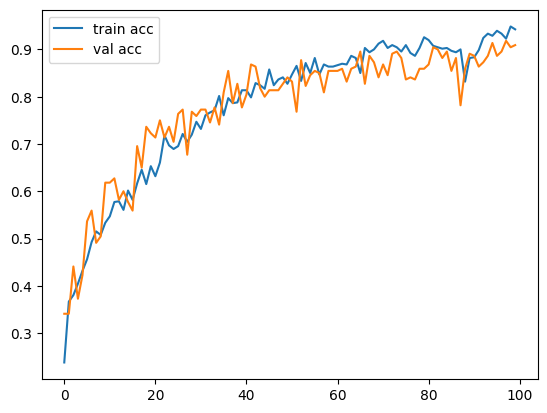

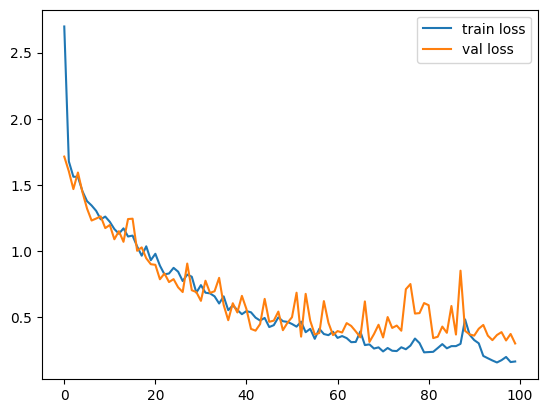

In [7]:
#@title Accuracy statistik graph

model.summary()

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()




# Image classification with TensorFlow Lite Model Maker with TensorFlow 2.18.0

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/tutorials/model_maker_image_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/model_maker_image_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/model_maker_image_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/tutorials/model_maker_image_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook has been moved [here](https://www.tensorflow.org/lite/tutorials/model_maker_image_classification).

In [8]:

print(tf.__version__)

2.18.0


https://colab.research.google.com/github/TrainingBear/OPSI-Project-AndroidApplication/blob/master/tensorflow_examples/lite/model_maker/demo/image_classification.ipynb#scrollTo=w7AdazbUlvDJ